<a href="https://colab.research.google.com/github/dheerajreddy2020/Vehicles-detection-and-Tracking-using-YOLO/blob/main/Yolo_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## Data Pre-processing

In [ ]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import tensorflow as tf

In [ ]:
loc='/content/drive/My Drive/Computer_Vision_Project/'
fname='Intersection Test Video_30mins.mp4'
fname = 'Taunton & Ritson_Trim.mp4'

In [ ]:
cap = cv2.VideoCapture(loc+fname)
total_frames = cap.get(7)
print(total_frames)
fps = cap.get(cv2.CAP_PROP_FPS)
video_length_sec =30*60+4
calculated_fps = total_frames/video_length_sec
print(f'Fps from software : {fps:.2f}')
print(f'Manually calculated fps : {calculated_fps:.2f}')

9072.0
Fps from software : 30.00
Manually calculated fps : 5.03


In [ ]:
int(total_frames/2)

4536

In [ ]:
loc='/content/drive/My Drive/Computer_Vision_Project/'
fname='Intersection Test Video_30mins.mp4'
cap = cv2.VideoCapture(loc+fname)
Total_frames = cap.get(7)
for i in range(total_frames):
    cap.set(1, i*3)
    ret, frame = cap.read()

In [ ]:
def del_dir(path):
  import os
  import shutil
  try:
    shutil.rmtree(path,ignore_errors=True)
  except OSError:
    print ("Deletion of the directory %s failed" % path)

In [ ]:
path = "/content/drive/My Drive/Computer_Vision_Project/frames"
del_dir(path)
import os
os.mkdir(path)

In [ ]:
import numpy as np
new_frame_list = np.arange(0,4800)
len(new_frame_list)

4800

In [ ]:
for i in new_frame_list:
    cap.set(1, i*6)
    ret, frame = cap.read()
    save_loc = loc+'/frames/'+'frame'+str(i)+'.jpg'
    cv2.imwrite(save_loc,frame)
#cv2.imshow('Frame',frame)

In [ ]:
New_frames = len(new_frame_list)
frames_loc=loc+'frames/'
files=[]

for i in range(New_frames):
    files.append(frames_loc+'frame'+str(i)+'.jpg')

In [ ]:
print('/content/drive/My Drive/Computer_Vision_Project/frames/frame0.jpg')
files[10]

/content/drive/My Drive/Computer_Vision_Project/frames/frame0.jpg


'/content/drive/My Drive/Computer_Vision_Project/frames/frame10.jpg'

In [ ]:
video_loc=loc+'Modified_Video/temp.mp4'
fps=30
def video_from_frames(files=files,fps=fps,video_loc=video_loc):
  frame_array = []
  for i in range(len(files)):
    print(i)
    filename=files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    #inserting the frames into an image array
    frame_array.append(img)
  out = cv2.VideoWriter(video_loc,cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
  for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
  out.release()

/content/drive/My Drive/Computer_Vision_Project/Modified_Video

In [ ]:
video_from_frames(fps=10)

# YOLO download

In [ ]:
!pip install h5py

In [ ]:
import struct
import numpy as np
import cv2
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model

 
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x
 
def make_yolov3_model():
	input_image = Input(shape=( 416, 416, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model
 
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')
 
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
 
	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))
 
	def reset(self):
		self.offset = 0
 
# define the model
model = make_yolov3_model()
model.summary()
# load the model weights
weight_reader = WeightReader('/content/drive/My Drive/Computer_Vision_Project/Yolo/yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('/content/drive/My Drive/Computer_Vision_Project/Yolo/model.h5')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

In [ ]:
# load yolov3 model
from keras.models import load_model
model = load_model('/content/drive/My Drive/Computer_Vision_Project/Yolo/model.h5')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

In [ ]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
from preprocessing_functions import *

In [ ]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import cv2
 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def correct_yolo_boxes2(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_h
        new_w = (image_w*net_h)/image_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def track_bboxes(boxes_previous,boxes_present,predicted_classes):
  tracked_classes = [None]*len(boxes_present)
  for j in range(len(boxes_present)):
    bbox_present = boxes_present[j]
    for i in range(len(boxes_previous)):
      bbox_previous = boxes_previous[i]
      iou_calc = bbox_iou(bbox_present, bbox_previous)
      #print(iou_calc)
      if iou_calc > 0.45:
        tracked_classes[j] = predicted_classes[i]
  return tracked_classes


def do_nms(boxes, nms_thresh):
  if len(boxes) > 0:
    nb_class = len(boxes[0].classes)
  else:
    return
  for c in range(nb_class):
    sorted_indices = np.argsort([-box.classes[c] for box in boxes])
    for i in range(len(sorted_indices)):
      index_i = sorted_indices[i]
      if boxes[index_i].classes[c] == 0: continue
      for j in range(i+1, len(sorted_indices)):
        index_j = sorted_indices[j]
        if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
          boxes[index_j].classes[c] = 0

def drop_boxes(boxes,obj_thresh, labels):
  drop_index = []
  for i in range(len(boxes)):
    label = -1
    for j in range(len(labels)):
      if boxes[i].classes[j] > obj_thresh:
        label = j
    if label < 0:
      drop_index.append(i)
  for k in range(len(drop_index)):
    boxes.pop(drop_index[k]-k)
    

# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

def mask_image(img,refPt):
    pts = np.array(refPt)
    mask = np.zeros(img.shape[:2], np.uint8)
    try:
      cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
      dst = cv2.bitwise_and(img, img, mask=mask)
    except:
      dst = img.copy()
    return dst

def load_image_pixels_new(image, shape, filename=None):
  # load the image to get its shape
  if filename:
    image = cv2.imread(filename)
  height, width = image.shape[:2]
  # load the image with the required size
  image = cv2.resize(image, shape)
  #image = cv2.GaussianBlur(image,(25,25),0)
  image = mask_image(image,refPt)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  #image = np.expand_dims(image, axis=0)
  # convert to numpy array
  #image = img_to_array(image)
  # scale pixel values to [0, 1]
  image = image.astype('float32')
  image /= 255.0
  # add a dimension so that we have one sample
  image = expand_dims(image, 0)
  return image, width, height


# get all of the results above a threshold
def draw_boxes_cv(image, boxes, k, tracking, save_crop=False):
    #crop_imgs = []
    predicted_classes = []
    l=k
    #loc='/content/drive/MyDrive/Computer_Vision_Project/Cropped_images/'
    #image=cv2.imread(fname)
    temp_image = image.copy()
    for i in range(len(boxes)):
        box = boxes[i]
        label_str = ''
        y1, x1, y2, x2 = int(box.ymin), int(box.xmin), int(box.ymax), int(box.xmax)
        crop_img = temp_image[y1:y2, x1:x2].copy()
        if tracking[i] is not None:
          new_class = tracking[i]
        else:
          new_class = predict_new_class(crop_img)
          count_dict[new_class]+=1
        predicted_classes.append(new_class)
        if new_class is not None :
          if save_crop:
            cv2.imwrite(loc+str(l)+'_'+new_class+'.jpg',crop_img)
            l+=1
          cv2.rectangle(image, (x1,y1), (x2,y2), (255,0,0), 2)
          cv2.putText(image, 
                      new_class, 
                      (box.xmin, box.ymin - 13), 
                      cv2.FONT_HERSHEY_SIMPLEX, 
                      1e-3 * image.shape[0], 
                      (0,255,0), 2)
    display_count(image,count_dict)
    return image,l,predicted_classes

def init_count_dict():
  count_dict = {}
  for key in class_dict.keys():
    count_dict[key] = 0
  return count_dict


def predict_new_class(img):
  class_from_number ={}
  for a,b in class_dict.items():
    class_from_number[str(b)] = a
  img = cv2.resize(img,(100,100))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=img/img.max()
  #x = img_to_array(img)
  x = np.expand_dims(img,axis=0)
  classes = new_model.predict(x)
  return class_from_number[str(np.argmax(classes))]


def display_count(img,count_dict):
  i=0
  for key,value in count_dict.items():
    i += 5
    cv2.putText(img, key+' : ', 
                      (5, 10+i*7), 
                      cv2.FONT_HERSHEY_SIMPLEX, 
                      1e-3 * img.shape[0], 
                      (0,128,255), 2)
    cv2.putText(img, str(value), 
                      (200, 10+i*7), 
                      cv2.FONT_HERSHEY_SIMPLEX, 
                      1e-3 * img.shape[0], 
                      (100,0,255), 2)

In [ ]:
class_dict = {'Class_0': 0, 'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 
              'Class_4': 4, 'Class_5': 5, 'Class_6': 6, 'Class_7': 7,
              'Class_bike': 8,  'None': 9,'Trailer': 10}
count_dict = init_count_dict()

In [ ]:
model = load_model('/content/drive/My Drive/Computer_Vision_Project/Yolo/model.h5')
new_model = load_model('/content/drive/MyDrive/Computer_Vision_Project/new_model.h5')
class_dict = {'Class_0': 0, 'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 
              'Class_4': 4, 'Class_5': 5, 'Class_6': 6, 'Class_7': 7,
              'Class_bike': 8,  'None': 9,'Trailer': 10}
count_dict = init_count_dict()
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
refPt = [[22, 173], [190, 114], [339, 147], [325, 339], [158, 409]]
class_threshold = 0.5
input_w, input_h = 416, 416
predicted_classes=[]
boxes_previous = []
labels = ["person", "bicycle", "car", "motorbike", "bus", "train", "truck"]
#k=0
loc='/content/drive/My Drive/Computer_Vision_Project/'
vname='Taunton & Ritson_Trim.mp4'
cap = cv2.VideoCapture(loc+vname)
total_frames = cap.get(7)
print(total_frames)
for i in range(int(total_frames/2)):
  print(i)
  cap.set(1, i*2)
  ret, frame = cap.read()
  fname = 'frame'+str(i)+'.jpg'
  image, image_w, image_h = load_image_pixels_new(frame, (input_w, input_h))
  # make prediction
  yhat = model.predict(image)
  # summarize the shape of the list of arrays
  # define the probability threshold for detected objects
  boxes = list()
  for j in range(len(yhat)):
	  # decode the output of the network
	  boxes += decode_netout(yhat[j][0], anchors[j], class_threshold, input_h, input_w)
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
  # suppress non-maximal boxes
  do_nms(boxes, 0.5)
  drop_boxes(boxes,class_threshold, labels)
  # get the details of the detected objects
  tracked_box_classes = track_bboxes(boxes_previous,boxes,predicted_classes)
  modified_img,k,predicted_classes = draw_boxes_cv(frame, boxes, k, tracking = tracked_box_classes)
  boxes_previous = boxes
  frames_loc='/content/drive/MyDrive/Computer_Vision_Project/Objects_detected/'
  cv2.imwrite(frames_loc+fname,modified_img)
#cv2_imshow(modified_img)

9072.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275

In [ ]:
model = load_model('/content/drive/My Drive/Computer_Vision_Project/Yolo/model.h5')
new_model = load_model('/content/drive/MyDrive/Computer_Vision_Project/new_model.h5')

9072.0
(1, 416, 416, 3)
10647
4
tracked_boxes :  ['None', 'Class_3', None, None]
['None', 'Class_3', 'Class_3', 'None']


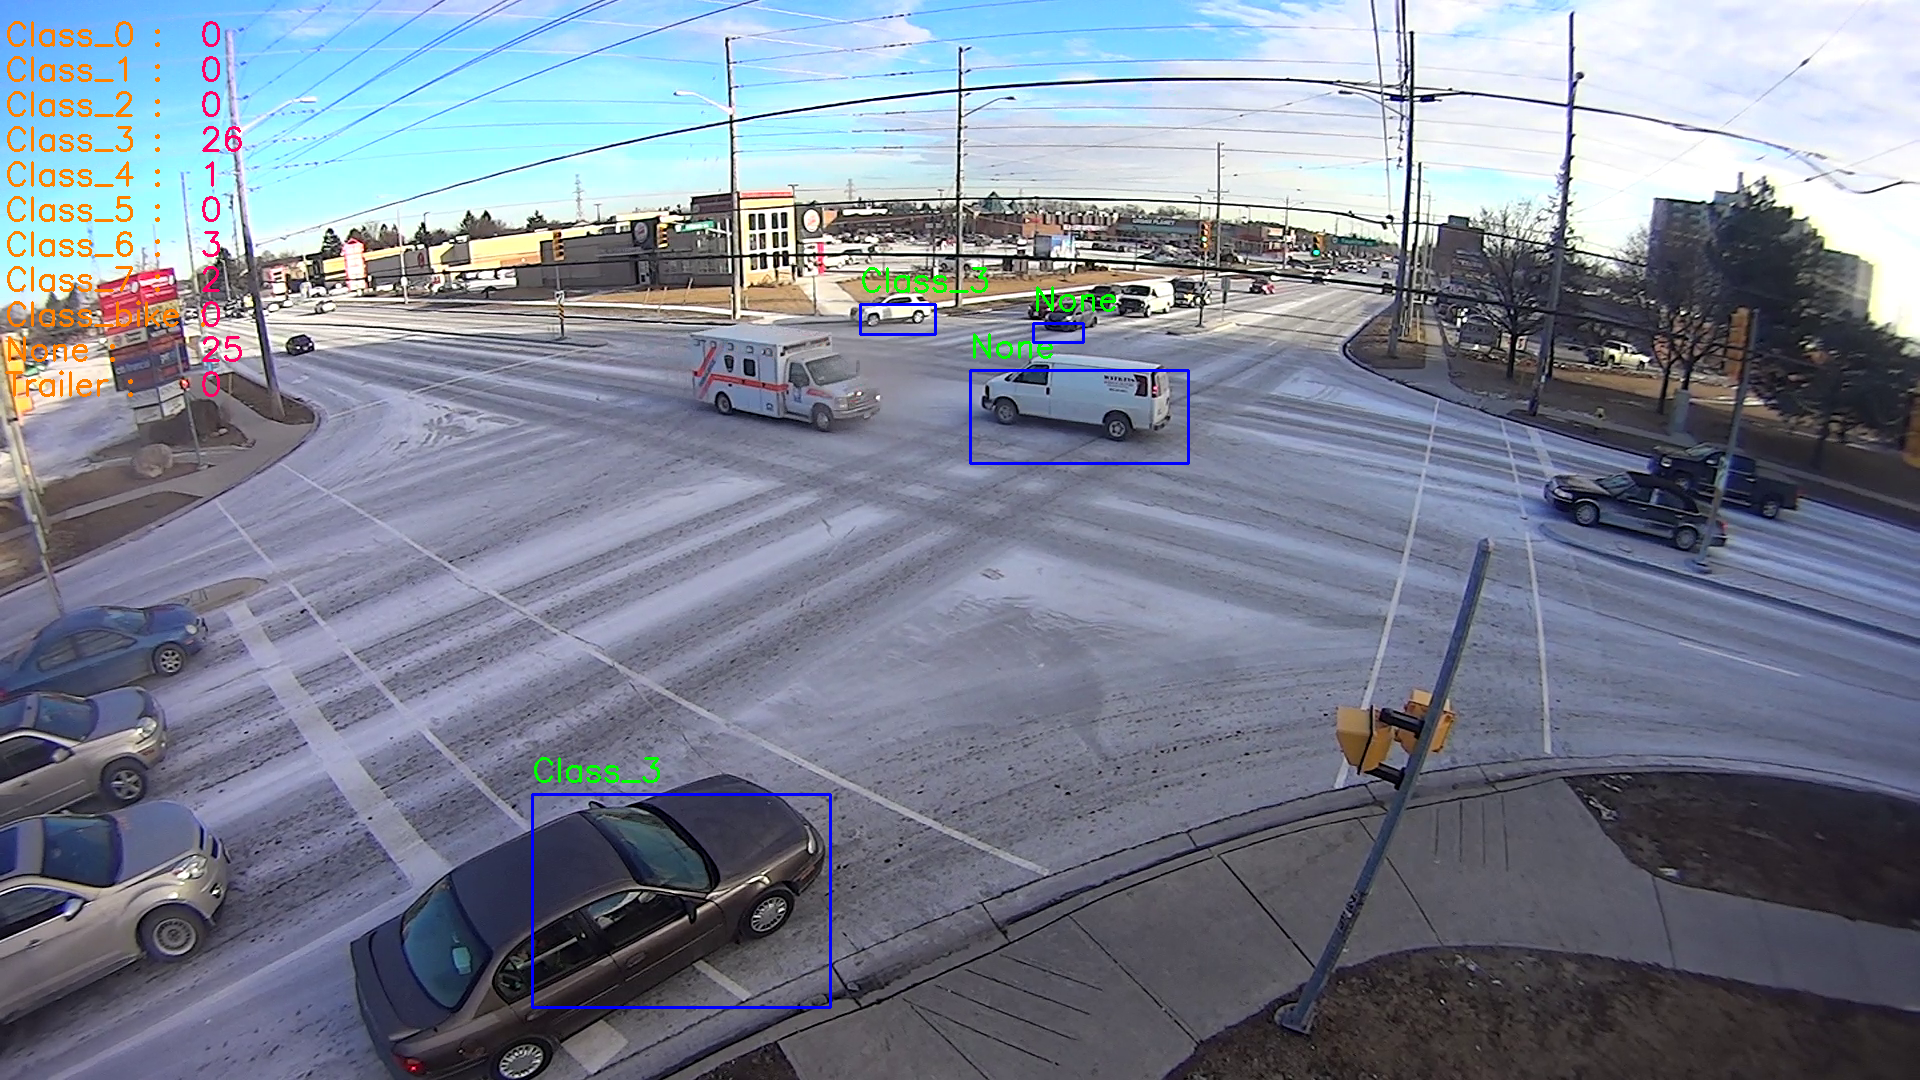

In [ ]:

anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
class_threshold = 0.25
input_w, input_h = 416, 416
refPt = []
#refPt = [[250, 199], [601, 115], [1015, 265], [528, 668]]
#refPt = [[180, 130], [670, 45], [1085, 335], [470, 740]]
refPt = [[22, 173], [190, 114], [339, 147], [325, 339], [158, 409]]
#predicted_classes=[]
#boxes_previous = []
loc='/content/drive/My Drive/Computer_Vision_Project/'
vname='Taunton & Ritson_Trim.mp4'
cap = cv2.VideoCapture(loc+vname)
total_frames = cap.get(7)
print(total_frames)
i = 1650
cap.set(1, i)
ret, frame = cap.read()
k=0
labels = ["person", "bicycle", "car", "motorbike", "bus", "train", "truck"]
# load yolov3 model
# define the expected input shape for the model
# define our new photo
#photo_filename = floc+fname
# load and prepare image
image, image_w, image_h = load_image_pixels_new(frame, (input_w, input_h))
print(image.shape)
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
# define the probability threshold for detected objects
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
print(len(boxes))
# suppress non-maximal boxes
do_nms(boxes, 0.5)
drop_boxes(boxes,class_threshold, labels)
print(len(boxes))
# define the labels
# get the details of the detected objects
tracked_box_classes = track_bboxes(boxes_previous,boxes,predicted_classes)
print('tracked_boxes : ',tracked_box_classes)
modified_img,k,predicted_classes = draw_boxes_cv(frame, boxes, k, tracking = tracked_box_classes)
#cap.release()
print(predicted_classes)
boxes_previous = boxes
cv2_imshow(modified_img)

In [ ]:
count_dict = init_count_dict()

def display_count(img,count_dict):
  i=0
  for key,value in count_dict.items():
    i += 5
    cv2.putText(img, key+' : ', 
                      (5, 10+i*7), 
                      cv2.FONT_HERSHEY_SIMPLEX, 
                      1e-3 * img.shape[0], 
                      (0,128,255), 2)
    cv2.putText(img, str(value), 
                      (200, 10+i*7), 
                      cv2.FONT_HERSHEY_SIMPLEX, 
                      1e-3 * img.shape[0], 
                      (100,0,255), 2)

In [ ]:
print(k)
print(crop_imgs[2].max())

0
255


In [ ]:
frames_loc='/content/drive/My Drive/Computer_Vision_Project/Objects_detected/'
files=[]
New_frames=total_frames//2
for i in range(0,1000):
    files.append(frames_loc+'frame'+str(i)+'.jpg')

In [ ]:
print(len(files))

1000


In [ ]:
video_loc='/content/drive/My Drive/Computer_Vision_Project/Modified_Video/final0.mp4'
video_from_frames(files=files,fps=15,video_loc=video_loc)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
def video_from_frames(files=files,fps=fps,video_loc=video_loc):
  frame_array = []
  for i in range(len(files)):
    print(i)
    filename=files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    #inserting the frames into an image array
    frame_array.append(img)
  out = cv2.VideoWriter(video_loc,cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
  for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
  out.release()